In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
sns.set()
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import tree, datasets, svm
from sklearn.metrics import accuracy_score
import math
# from KaggleAux import predict as ka

In [40]:
train_data = pd.read_csv("./raw/cs-training.csv", index_col=[0]);
test_data = pd.read_csv("./raw/cs-test.csv", index_col=[0]);

# Data profiling

In [41]:
# Get a first glimpse at data
train_data.head(5)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
SeriousDlqin2yrs                        150000 non-null int64
RevolvingUtilizationOfUnsecuredLines    150000 non-null float64
age                                     150000 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    150000 non-null int64
DebtRatio                               150000 non-null float64
MonthlyIncome                           120269 non-null float64
NumberOfOpenCreditLinesAndLoans         150000 non-null int64
NumberOfTimes90DaysLate                 150000 non-null int64
NumberRealEstateLoansOrLines            150000 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    150000 non-null int64
NumberOfDependents                      146076 non-null float64
dtypes: float64(4), int64(7)
memory usage: 13.7 MB


**MonthlyIncome** has 29731 missing values out of 150000 entries (19,8% missing...).
It will be critical to decide what to do with this value: either ignore it or try to guess it.

#### Quick descriptive stats

In [42]:
# Summary stats
# Why we don't use .summary() ==> to add more stats like skew and median + have a more readable table view

def build_summary(dataframe):
    df = pd.DataFrame()
    df = df.append(dataframe.count(numeric_only=True), ignore_index=True)
    df = df.append(dataframe.isnull().sum(), ignore_index=True)
    df = df.append(dataframe.sum(numeric_only=True), ignore_index=True)
    df = df.append(dataframe.mean(numeric_only=True), ignore_index=True)
    df = df.append(dataframe.std(numeric_only=True), ignore_index=True)
    df = df.append(dataframe.median(numeric_only=True), ignore_index=True)
    df = df.append(dataframe.min(numeric_only=True), ignore_index=True)
    df = df.append(dataframe.max(numeric_only=True), ignore_index=True)
    df = df.append(dataframe.skew(numeric_only=True), ignore_index=True)
    df = df.append(dataframe.mode(numeric_only=True), ignore_index=True)
    df.rename(index={0: 'COUNT', 1: 'NaN', 2: 'SUM', 3: 'MEAN', 4: 'STD', 5: 'MEDIAN', 6: 'MIN', 7: 'MAX', 8: 'SKEW', 9: 'MODE' }, inplace=True)
    return df
build_summary(train_data)

,DebtRatio,MonthlyIncome,NumberOfDependents,NumberOfOpenCreditLinesAndLoans,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,RevolvingUtilizationOfUnsecuredLines,SeriousDlqin2yrs,age
COUNT,1.500000e+05,1.202690e+05,146076.000000,1.500000e+05,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.500000e+05
NaN,0.000000e+00,2.973100e+04,3924.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
SUM,5.295076e+07,8.022208e+08,110612.000000,1.267914e+06,63155.000000,36058.000000,39896.000000,152736.000000,907265.708200,10026.000000,7.844281e+06
MEAN,3.530051e+02,6.670221e+03,0.757222,8.452760e+00,0.421033,0.240387,0.265973,1.018240,6.048438,0.066840,5.229521e+01
STD,2.037819e+03,1.438467e+04,1.115086,5.145951e+00,4.192781,4.155179,4.169304,1.129771,249.755371,0.249746,1.477187e+01
MEDIAN,3.665078e-01,5.400000e+03,0.000000,8.000000e+00,0.000000,0.000000,0.000000,1.000000,0.154181,0.000000,5.200000e+01
MIN,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
MAX,3.296640e+05,3.008750e+06,20.000000,5.800000e+01,98.000000,98.000000,98.000000,54.000000,50708.000000,1.000000,1.090000e+02
SKEW,9.515779e+01,1.140403e+02,1.588242,1.215314e+00,22.597108,23.331743,23.087345,3.482484,97.631574,3.468857,1.889945e-01
MODE,0.000000e+00,5.000000e+03,0.000000,6.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.900000e+01


{'whiskers': [<matplotlib.lines.Line2D at 0x7f5b5dd5d208>,
 'caps': [<matplotlib.lines.Line2D at 0x7f5b5dd5dc18>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f5b5dd5d048>,
 'medians': [<matplotlib.lines.Line2D at 0x7f5b5dd65588>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f5b5dd65a20>,
 'means': []}

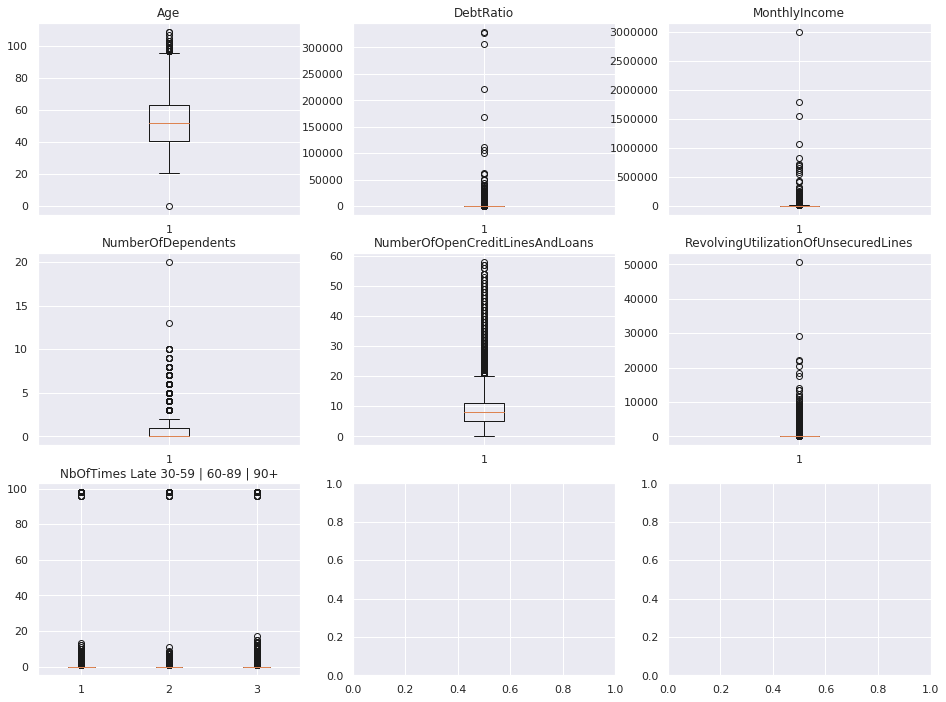

In [7]:
fig, subaxes = plt.subplots(3, 3, figsize=(16,12))

plt.subplot(3,3,1)
plt.title('Age')
plt.boxplot(train_data["age"].dropna())

plt.subplot(3,3,2)
plt.title('DebtRatio')
plt.boxplot(train_data["DebtRatio"].dropna())

plt.subplot(3,3,3)
plt.title('MonthlyIncome')
plt.boxplot(train_data["MonthlyIncome"].dropna())

plt.subplot(3,3,4)
plt.title('NumberOfDependents')
plt.boxplot(train_data["NumberOfDependents"].dropna())

plt.subplot(3,3,5)
plt.title('NumberOfOpenCreditLinesAndLoans')
plt.boxplot(train_data["NumberOfOpenCreditLinesAndLoans"].dropna())

plt.subplot(3,3,6)
plt.title('RevolvingUtilizationOfUnsecuredLines')
plt.boxplot(train_data["RevolvingUtilizationOfUnsecuredLines"].dropna())

plt.subplot(3,3,7)
plt.title('NbOfTimes Late 30-59 | 60-89 | 90+')
plt.boxplot([train_data["NumberOfTime30-59DaysPastDueNotWorse"].dropna(), train_data["NumberOfTime60-89DaysPastDueNotWorse"].dropna(), train_data["NumberOfTimes90DaysLate"].dropna()])


## Dictionnaire des data

**SeriousDlqin2yrs** = defaut de paiement d'un client, c'est notre variable a predire.

**RevolvingUtilizationOfUnsecuredLines** = % de crédit utilise (toutes cartes de credit confondues hors biens immobiliers)

**age** = age du client

**DebtRatio** = Taux de depenses par rapport aux revenus

**MonthlyIncome** = Revenu mensuel

**NumberOfOpenCreditLinesAndLoans** = Nombre de ligne de credit ouvertes

**NumberRealEstateLoansOrLines** = Nombre de credit immobilier ou hypotheques

**NumberOfDependents** = Nombre de personnes a charge

**NumberOfTime30-59DaysPastDueNotWorse** = Nombre de fois que l'emprunteur a ete en souffrance de paiement de 30 a 59 jours dans les 2 dernieres annees.

**NumberOfTime60-89DaysPastDueNotWorse** = Nombre de fois que l'emprunteur a ete en souffrance de paiement de 60 a 89 jours dans les 2 dernieres annees.

**NumberOfTimes90DaysLate** = Nombre de fois que l'emprunteur a ete en souffrance de paiement de paiement de 90 jours ou plus



# Analyses basiques

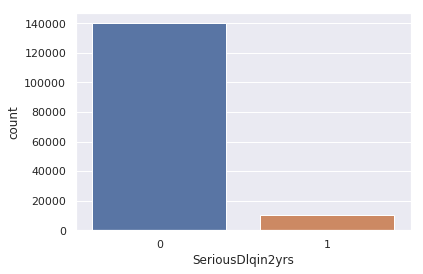

In [8]:
sns.countplot(x='SeriousDlqin2yrs', data=train_data);

In [9]:
# There's 14x MORE paying customers than NON-paying ones...
# Let's get a quick prediction base... everybody pays :)
test_data['SeriousDlqin2yrs'] = 0
test_data['id'] = test_data.index
test_data[['id', 'SeriousDlqin2yrs']].to_csv('./predictions/everybody_pays.csv', index=None, header=['id', 'Probability'])
# kaggle competitions submit -c GiveMeSomeCredit -f ~/Documents/fil_rouge/predictions/everybody_pays.csv -m "Testing dummy submission: everybody pays"
# Kaggle score: 0.5000 (we're nnot even the last in the board !!!)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  import sys


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5b5bbc27b8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f5b5f0bc588>]], dtype=object)

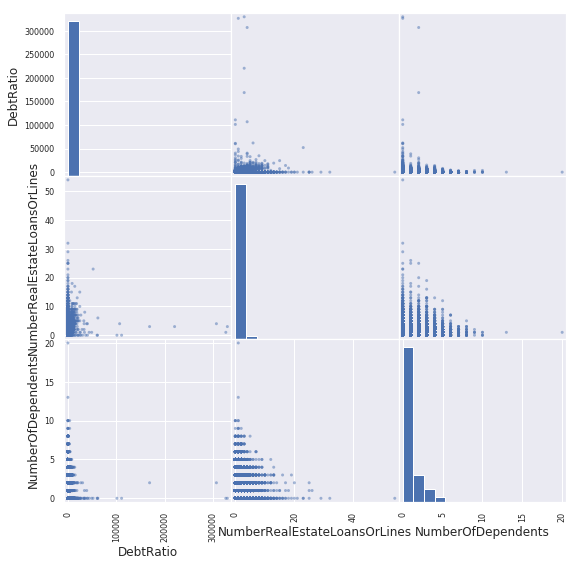

In [10]:
# train_data.keys()
# 'SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 
# 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
# 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
# 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents'

pd.scatter_matrix(train_data[["DebtRatio","NumberRealEstateLoansOrLines", "NumberOfDependents"]], hist_kwds={'bins':15}, figsize=(9,9))


In [43]:
NumDepsSummary = train_data.fillna("NaN").groupby('NumberOfDependents', as_index=False).agg({"SeriousDlqin2yrs": ["sum", "count"]})
NumDepsSummary['ratio']  = NumDepsSummary["SeriousDlqin2yrs"]["sum"]/NumDepsSummary["SeriousDlqin2yrs"]["count"]
NumDepsSummary

NumberOfDependents SeriousDlqin2yrs            ratio
                                   sum  count          
0                   0             5095  86902  0.058629
1                   1             1935  26316  0.073529
2                   2             1584  19522  0.081139
3                   3              837   9483  0.088263
4                   4              297   2862  0.103774
5                   5               68    746  0.091153
6                   6               24    158  0.151899
7                   7                5     51  0.098039
8                   8                2     24  0.083333
9                   9                0      5  0.000000
10                 10                0      5  0.000000
11                 13                0      1  0.000000
12                 20                0      1  0.000000
13                NaN              179   3924  0.045617

More dependents = more risks ??
Not really clear at this point as the distribution of this ratio seems rather normal with a peak between 4 and 6 dependents representing more risks.
We should be carefull with this dimension as it seems to partially explain risk. In fact, intuitively we can understand that a person with 20 dependents but without debts is more likely to pay than another person with 0 dependents but a 200% debt ratio... 
We might take this feature as a ponderation factor, but not as deterministic factor. For exemple, a person with 6 dependents AND a 100% debt ratio COMBINED might have a higher failure probability.

Finally, we will need to handle some null (NaN) values, either by removing or filling them.

age SeriousDlqin2yrs           ratio
                     sum count          
0     0                0     1  0.000000
1    21               13   183  0.071038
2    22               36   434  0.082949
3    23               70   641  0.109204
4    24               98   816  0.120098
5    25              121   953  0.126967
6    26              147  1193  0.123219
7    27              166  1338  0.124066
8    28              205  1560  0.131410
9    29              179  1702  0.105170
10   30              209  1937  0.107899
11   31              217  2038  0.106477
12   32              233  2050  0.113659
13   33              246  2239  0.109870
14   34              210  2155  0.097448
15   35              241  2246  0.107302
16   36              237  2379  0.099622
17   37              227  2521  0.090044
18   38              235  2631  0.089320
19   39              280  2987  0.093740
20   40              264  3093  0.085354
21   41              294  3122  0.094170
22   42              289  3082  0.093770
23   43              276  3208  0.086035
24   44              242  3294  0.073467
25   45              284  3502  0.081097
26   46              324  3714  0.087237
27   47              306  3719  0.082280
28   48              286  3806  0.075145
29   49              313  3837  0.081574
..  ...              ...   ...       ...
56   76               24  1183  0.020287
57   77               18  1099  0.016379
58   78               24  1054  0.022770
59   79               22   981  0.022426
60   80               19   876  0.021689
61   81                9   774  0.011628
62   82               19   647  0.029366
63   83               10   512  0.019531
64   84                8   480  0.016667
65   85                9   483  0.018634
66   86                6   407  0.014742
67   87                8   357  0.022409
68   88                8   313  0.025559
69   89                9   276  0.032609
70   90                3   198  0.015152
71   91                5   154  0.032468
72   92                0    93  0.000000
73   93                1    87  0.011494
74   94                1    47  0.021277
75   95                1    45  0.022222
76   96                0    18  0.000000
77   97                0    17  0.000000
78   98                0     6  0.000000
79   99                2     9  0.222222
80  101                1     3  0.333333
81  102                0     3  0.000000
82  103                0     3  0.000000
83  105                0     1  0.000000
84  107                0     1  0.000000
85  109                0     2  0.000000

[86 rows x 4 columns]

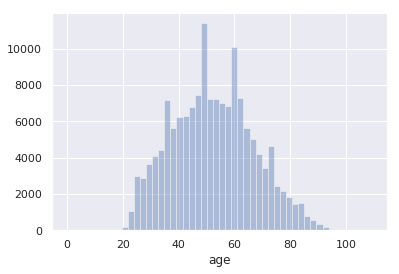

In [44]:
sns.distplot(train_data.age, kde=False);
AgeSummary = train_data.fillna("NaN").groupby('age', as_index=False).agg({"SeriousDlqin2yrs": ["sum", "count"]})
AgeSummary['ratio']  = AgeSummary["SeriousDlqin2yrs"]["sum"]/AgeSummary["SeriousDlqin2yrs"]["count"]
AgeSummary

Even though further analysis is needed at this stage, this view suggests that age is a crucial factor when it comes to pay back credits. Younger people tends to fail more that older ones.

In [45]:
# train_data.loc[train_data['DebtRatio']*100 <= 100, 'DebtRatioRange'] = np.ceil(train_data["DebtRatio"]*100)
# train_data.loc[train_data['DebtRatio']*100 > 100, 'DebtRatioRange'] = 101

# train_data

train_data["DebtRatioRange"] = pd.qcut(train_data["DebtRatio"],4)

DebtRatioSummary = train_data.groupby("DebtRatioRange").agg({"SeriousDlqin2yrs": ["sum", "count"]})
DebtRatioSummary['ratio']  = DebtRatioSummary["SeriousDlqin2yrs"]["sum"]/DebtRatioSummary["SeriousDlqin2yrs"]["count"]
DebtRatioSummary


# sns.distplot(train_data.DebtRatio, kde=False);
# train_data.groupby('SeriousDlqin2yrs').DebtRatio.hist(alpha=0.6);

# sns.stripplot(x='SeriousDlqin2yrs', y='DebtRatio', data=train_data, alpha=0.3, jitter=True);
# sns.swarmplot(x='SeriousDlqin2yrs', y='DebtRatio', data=train_data);

SeriousDlqin2yrs            ratio
                               sum  count          
DebtRatioRange                                     
(-0.001, 0.175]               2281  37500  0.060827
(0.175, 0.367]                2107  37500  0.056187
(0.367, 0.868]                3082  37500  0.082187
(0.868, 329664.0]             2556  37500  0.068160

# Data cleaning

In [160]:
# Replacing missing values with the median
# Why the median ? 
# Because in our summary stats, we see that both MonthlyIncome and NumberOfDependents are highly skewed
# This denotes that the mean is not really relevant in those distributions
train_data['MonthlyIncome'].fillna(train_data['MonthlyIncome'].median(), inplace=True)
train_data['NumberOfDependents'].fillna(train_data['NumberOfDependents'].median(), inplace=True)

build_summary(train_data)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,DebtRatio,DebtRatioRange,MonthlyIncome,NumberOfDependents,NumberOfOpenCreditLinesAndLoans,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,RevolvingUtilizationOfUnsecuredLines,SeriousDlqin2yrs,age
COUNT,1.500000e+05,NaN,1.500000e+05,150000.000000,1.500000e+05,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.500000e+05
NaN,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
SUM,5.295076e+07,NaN,9.627682e+08,110612.000000,1.267914e+06,63155.000000,36058.000000,39896.000000,152736.000000,907265.708200,10026.000000,7.844281e+06
MEAN,3.530051e+02,NaN,6.418455e+03,0.737413,8.452760e+00,0.421033,0.240387,0.265973,1.018240,6.048438,0.066840,5.229521e+01
STD,2.037819e+03,NaN,1.289040e+04,1.107021,5.145951e+00,4.192781,4.155179,4.169304,1.129771,249.755371,0.249746,1.477187e+01
MEDIAN,3.665078e-01,NaN,5.400000e+03,0.000000,8.000000e+00,0.000000,0.000000,0.000000,1.000000,0.154181,0.000000,5.200000e+01
MIN,0.000000e+00,NaN,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
MAX,3.296640e+05,NaN,3.008750e+06,20.000000,5.800000e+01,98.000000,98.000000,98.000000,54.000000,50708.000000,1.000000,1.090000e+02
SKEW,9.515779e+01,NaN,1.271217e+02,1.626059,1.215314e+00,22.597108,23.331743,23.087345,3.482484,97.631574,3.468857,1.889945e-01
MODE,0.000000e+00,NaN,5.400000e+03,0.000000,6.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.900000e+01


In [49]:
# Eliminate outliers
# We eliminate rows where features have values exceeding 3x the standard deviation

train_data_filtered=train_data[np.abs(train_data["DebtRatio"]-train_data["DebtRatio"].mean()) <= (3*train_data["DebtRatio"].std())]
train_data_filtered=train_data[np.abs(train_data["MonthlyIncome"]-train_data["MonthlyIncome"].mean()) <= (3*train_data["MonthlyIncome"].std())]
train_data_filtered=train_data[np.abs(train_data["NumberOfDependents"]-train_data["NumberOfDependents"].mean()) <= (3*train_data["NumberOfDependents"].std())]
train_data_filtered=train_data[np.abs(train_data["NumberOfOpenCreditLinesAndLoans"]-train_data["NumberOfOpenCreditLinesAndLoans"].mean()) <= (3*train_data["NumberOfOpenCreditLinesAndLoans"].std())]
train_data_filtered=train_data[np.abs(train_data["NumberOfTime30-59DaysPastDueNotWorse"]-train_data["NumberOfTime30-59DaysPastDueNotWorse"].mean()) <= (3*train_data["NumberOfTime30-59DaysPastDueNotWorse"].std())]
train_data_filtered=train_data[np.abs(train_data["NumberOfTime60-89DaysPastDueNotWorse"]-train_data["NumberOfTime60-89DaysPastDueNotWorse"].mean()) <= (3*train_data["NumberOfTime60-89DaysPastDueNotWorse"].std())]
train_data_filtered=train_data[np.abs(train_data["NumberOfTimes90DaysLate"]-train_data["NumberOfTimes90DaysLate"].mean()) <= (3*train_data["NumberOfTimes90DaysLate"].std())]
train_data_filtered=train_data[np.abs(train_data["NumberRealEstateLoansOrLines"]-train_data["NumberRealEstateLoansOrLines"].mean()) <= (3*train_data["NumberRealEstateLoansOrLines"].std())]
train_data_filtered=train_data[np.abs(train_data["RevolvingUtilizationOfUnsecuredLines"]-train_data["RevolvingUtilizationOfUnsecuredLines"].mean()) <= (3*train_data["RevolvingUtilizationOfUnsecuredLines"].std())]
train_data_filtered=train_data[np.abs(train_data["age"]-train_data["age"].mean()) <= (3*train_data["age"].std())]

build_summary(train_data_filtered)
# Elimitated 46 rows in total which is really insignificant

,DebtRatio,DebtRatioRange,MonthlyIncome,NumberOfDependents,NumberOfOpenCreditLinesAndLoans,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,RevolvingUtilizationOfUnsecuredLines,SeriousDlqin2yrs,age
COUNT,1.499540e+05,NaN,1.499540e+05,149954.000000,1.499540e+05,149954.000000,149954.000000,149954.000000,149954.000000,149954.000000,149954.000000,1.499540e+05
NaN,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
SUM,5.294444e+07,NaN,9.625567e+08,110608.000000,1.267642e+06,63150.000000,36056.000000,39895.000000,152726.000000,907260.467732,10023.000000,7.839805e+06
MEAN,3.530712e+02,NaN,6.419013e+03,0.737613,8.453539e+00,0.421129,0.240447,0.266048,1.018486,6.050259,0.066840,5.228140e+01
STD,2.038113e+03,NaN,1.289229e+04,1.107116,5.146048e+00,4.193416,4.155814,4.169940,1.129816,249.793654,0.249746,1.475079e+01
MEDIAN,3.665257e-01,NaN,5.400000e+03,0.000000,8.000000e+00,0.000000,0.000000,0.000000,1.000000,0.154311,0.000000,5.200000e+01
MIN,0.000000e+00,NaN,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.100000e+01
MAX,3.296640e+05,NaN,3.008750e+06,20.000000,5.800000e+01,98.000000,98.000000,98.000000,54.000000,50708.000000,1.000000,9.600000e+01
SKEW,9.514556e+01,NaN,1.271046e+02,1.625677,1.215312e+00,22.593714,23.328172,23.083801,3.482657,97.616607,3.468841,1.830178e-01
MODE,0.000000e+00,NaN,5.400000e+03,0.000000,6.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.900000e+01


In [68]:
# Cleaning the test set with training set's conclusions (using training set's median)
test_data["SeriousDlqin2yrs"] = 0
test_data['MonthlyIncome'].fillna(train_data['MonthlyIncome'].median(), inplace=True)
test_data['NumberOfDependents'].fillna(train_data['NumberOfDependents'].median(), inplace=True)

build_summary(test_data)

,DebtRatio,MonthlyIncome,NumberOfDependents,NumberOfOpenCreditLinesAndLoans,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,RevolvingUtilizationOfUnsecuredLines,SeriousDlqin2yrs,age
COUNT,1.015030e+05,1.015030e+05,101503.000000,101503.000000,101503.000000,101503.000000,101503.000000,101503.000000,101503.000000,101503.0,1.015030e+05
NaN,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000e+00
SUM,3.496525e+07,6.665561e+08,76041.000000,858057.000000,46059.000000,27438.000000,30115.000000,102830.000000,538980.960125,0.0,5.319309e+06
MEAN,3.444750e+02,6.566861e+03,0.749150,8.453514,0.453770,0.270317,0.296691,1.013074,5.310000,0.0,5.240544e+01
STD,1.632595e+03,3.269909e+04,1.128600,5.144100,4.538487,4.503578,4.515859,1.110253,196.156039,0.0,1.477976e+01
MEDIAN,3.642597e-01,5.400000e+03,0.000000,8.000000,0.000000,0.000000,0.000000,1.000000,0.152586,0.0,5.200000e+01
MIN,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.100000e+01
MAX,2.683260e+05,7.727000e+06,43.000000,85.000000,98.000000,98.000000,98.000000,37.000000,21821.000000,0.0,1.040000e+02
SKEW,7.319086e+01,1.777344e+02,2.111209,1.225229,20.941244,21.541431,21.355956,2.790101,58.324982,0.0,1.870657e-01
MODE,0.000000e+00,5.400000e+03,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,5.000000e+01


In [162]:
# Splitting Training Vs Testing set
from sklearn import model_selection

cols = ["DebtRatio","MonthlyIncome","NumberOfDependents","NumberOfOpenCreditLinesAndLoans","NumberOfTime30-59DaysPastDueNotWorse","NumberOfTime60-89DaysPastDueNotWorse","NumberOfTimes90DaysLate","NumberRealEstateLoansOrLines","RevolvingUtilizationOfUnsecuredLines","age"]

# Split in-house data
X=train_data[cols].values
y=train_data.SeriousDlqin2yrs
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=45000, random_state=42)


# Use real world "test" file
real_data_list = [train_data]+[test_data]
concatenated_data = pd.concat(real_data_list)

X_real=concatenated_data[cols].values
y_real=concatenated_data.SeriousDlqin2yrs

X_real_train=train_data[cols].values
y_real_train=train_data.SeriousDlqin2yrs
X_real_test=test_data[cols].values
y_real_test=test_data.SeriousDlqin2yrs

In [165]:
# Applying a classification model: logistic regression
from sklearn.linear_model import LogisticRegression

# Training model on in-house test data
lr = LogisticRegression()
model = lr.fit(X_train, y_train)
print('Score with in-house test split {}'.format(lr.score(X,y)))


# Submitting to KAGGLE with real-world "test" data
model = lr.fit(X_real_train, y_real_train)
y_pred_proba = model.predict_proba(X_real_test)
t_proba = pd.DataFrame({"SeriousDlqin2yrs":y_pred_proba[:,1]})
t_proba['id'] = t_proba.index + 1
t_proba[['id', 'SeriousDlqin2yrs']].to_csv('./predictions/linear_regression.csv', index=None, header=['id', 'Probability'])

# kaggle competitions submit -c GiveMeSomeCredit -f ~/Documents/fil_rouge/predictions/linear_regression.csv -m "Testing linear regression submission"
# We get public score of 0.700624


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Score with in-house test split 0.93404


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Linear regression gives us a pretty big difference between our in-house score and the one returned by our Kaggle submission. One reason may be because, as its name implies, it is a linear model thus rather impacted by new data distribution. In our case, our real-world test set may contain another population than the labeled training set we've been given.
For this reason, let's try a non-linear classification model.

In [166]:
# Random Forest is the swiss knife of ML as it can be efficient in plenty of ML applications: 
#                                              classification, regression, feature reduction.
# And it is a non-linear model: just what we're looking for !
# Let's apply it to our context, in contrast with our earlier linear model

from sklearn.ensemble import RandomForestClassifier

# Training model on in-house test data
randFor = RandomForestClassifier()
randFor.fit(X_train, y_train)

print('Score with in-house test split {}'.format(randFor.score(X,y)))


# Submitting to KAGGLE with real-world "test" data
randFor = RandomForestClassifier()
randFor.fit(X_real_train, y_real_train)
rf_pred_proba = clf.predict_proba(X_real_test)
rf_proba = pd.DataFrame({"SeriousDlqin2yrs":rf_pred_proba[:,1]})
rf_proba['id'] = rf_proba.index + 1
rf_proba[['id', 'SeriousDlqin2yrs']].to_csv('./predictions/random_forest.csv', index=None, header=['id', 'Probability'])

# kaggle competitions submit -c GiveMeSomeCredit -f ~/Documents/fil_rouge/predictions/random_forest.csv -m "Testing random forest submission"
# We get public score of 0.780633
# --> We should play with hyper parameters of the RandomForestClassifier using GridSearch


# feature_importances_ gives us resulting features reduction: 
importance_matrix = pd.DataFrame({"Feature":cols, "Importance":randFor.feature_importances_}).sort_values("Importance",ascending=False).reset_index(drop=True)

importance_matrix




/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Score with in-house test split 0.9737266666666666


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,Feature,Importance
0,RevolvingUtilizationOfUnsecuredLines,0.197914
1,DebtRatio,0.182128
2,MonthlyIncome,0.145652
3,age,0.128842
4,NumberOfOpenCreditLinesAndLoans,0.087111
5,NumberOfTimes90DaysLate,0.077747
6,NumberOfTime60-89DaysPastDueNotWorse,0.062109
7,NumberOfTime30-59DaysPastDueNotWorse,0.044513
8,NumberOfDependents,0.040209
9,NumberRealEstateLoansOrLines,0.033775
